## Classification without contrastive learning pretraining

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
dtd_folder = '/home/gridsan/ckoevesdi/data/dtd_torch/dtd/dtd/'

cuda:0


In [2]:
loading_transforms = transforms.Compose([
    transforms.CenterCrop(size=256),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This will also convert the image from [0, 255] to [0.0, 1.0]
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
class_dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/dtd_torch/', split='train', 
                                             partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen
# Define the batch size (Change this based on your requirements)
batch_size = 1

# Create a DataLoader
classification_dataloader = DataLoader(
    class_dtd_dataset,
    batch_size=batch_size,
    shuffle=False
)
tensor2pil_transform = transforms.ToPILImage()

In [3]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     256,
                                     256)).to(device)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(classification_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
labels_array = np.array([item['original_image_index'] for item in all_statistics])
print(statistics_array.shape)

# Standardize
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(statistics_array)
#scaled_array = statistics_array

# Convert NumPy arrays to PyTorch tensors
statistics_tensor = torch.tensor(scaled_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)
#print(statistics_tensor[2])


(4183, 150)


In [6]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)

batches = 100
class_statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

In [7]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(150, 100)
        self.layer2 = nn.Linear(100, 75)
        self.layer3 = nn.Linear(75, 60)
        self.layer4 = nn.Linear(60, 47)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=47, bias=True)
)


In [8]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.layer1 = nn.Linear(150, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 47)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(F.relu(self.layer2(x)))
        x = F.relu(self.layer3(x))
        x = self.bn2(x)
        x = self.dropout(F.relu(self.layer4(x)))
        x = F.relu(self.layer5(x))
        x = self.layer6(x)
        return x


## Training loop

In [8]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim
model = EmbeddingModel()
#model = ImprovedModel()

model.to(device)
classification_loss = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

In [9]:
# Training loop
num_epochs = 100 # Number of epochs for fine-tuning

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0

for epoch in range(num_epochs):
    for x_batch, y_batch in class_statistics_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        #print(y_batch.shape)
        # Forward pass
        outputs = model(x_batch)
        #print(outputs.shape)
        # Compute loss
        loss = classification_loss(outputs, y_batch)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

    # Calculate accuracy for this epoch
    epoch_accuracy = 100 * correct_samples / total_samples

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Reset accuracy tracking variables for the next epoch
    total_samples = 0
    correct_samples = 0

Epoch [1/100], Loss: 3.6713, Accuracy: 3.73%
Epoch [2/100], Loss: 3.3779, Accuracy: 8.37%
Epoch [3/100], Loss: 3.5592, Accuracy: 11.81%
Epoch [4/100], Loss: 3.1555, Accuracy: 14.22%
Epoch [5/100], Loss: 3.1186, Accuracy: 15.63%
Epoch [6/100], Loss: 3.3215, Accuracy: 17.02%
Epoch [7/100], Loss: 3.0245, Accuracy: 18.10%
Epoch [8/100], Loss: 2.9407, Accuracy: 18.67%
Epoch [9/100], Loss: 3.0542, Accuracy: 19.84%
Epoch [10/100], Loss: 2.7856, Accuracy: 20.44%
Epoch [11/100], Loss: 2.8702, Accuracy: 21.30%
Epoch [12/100], Loss: 2.7955, Accuracy: 22.14%
Epoch [13/100], Loss: 2.9652, Accuracy: 22.59%
Epoch [14/100], Loss: 3.0041, Accuracy: 22.76%
Epoch [15/100], Loss: 2.8112, Accuracy: 24.24%
Epoch [16/100], Loss: 2.9386, Accuracy: 24.74%
Epoch [17/100], Loss: 2.5597, Accuracy: 24.43%
Epoch [18/100], Loss: 2.7916, Accuracy: 25.25%
Epoch [19/100], Loss: 2.5999, Accuracy: 26.78%
Epoch [20/100], Loss: 2.8636, Accuracy: 26.94%
Epoch [21/100], Loss: 2.4860, Accuracy: 28.02%
Epoch [22/100], Loss: 2.

## Test accuracy

In [12]:
loading_transforms = transforms.Compose([
    transforms.CenterCrop(size=256),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This will also convert the image from [0, 255] to [0.0, 1.0]
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
test_dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/dtd_torch/', split='test', 
                                            partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen
# Define the batch size (Change this based on your requirements)
batch_size = 1

# Create a DataLoader
test_classification_dataloader = DataLoader(
    test_dtd_dataset,
    batch_size=batch_size,
    shuffle=False
)
tensor2pil_transform = transforms.ToPILImage()
print(len(test_dtd_dataset))

517


In [13]:
test_all_statistics = []

for j, (texture_batch, labels) in enumerate(test_classification_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    test_all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
print(test_statistics_array.shape)
# Standardize

#scaler = StandardScaler()
#scaler = MinMaxScaler()
test_scaled_array = scaler.transform(test_statistics_array)
#test_scaled_array = test_statistics_array

# Convert NumPy arrays to PyTorch tensors
test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

(517, 150)


In [15]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

batches = 80
test_class_statistics_dataloader = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=True)

In [16]:
model.eval()

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0
all_preds = []
all_labels = []
# Disable gradient calculation
with torch.no_grad():
    for x_batch, y_batch in test_class_statistics_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        
        # Forward pass
        outputs = model(x_batch)
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

# Calculate accuracy for the test set
test_accuracy = 100 * correct_samples / total_samples

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Set the model back to training mode (optional if you continue training afterwards)
model.train()


Test Accuracy: 18.57%


EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=47, bias=True)
)

In [17]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
# Convert to NumPy arrays for easier slicing and indexing
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate the classification report
#print(classification_report(all_labels, all_preds))

# Generate the confusion matrix
#print(confusion_matrix(all_labels, all_preds))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


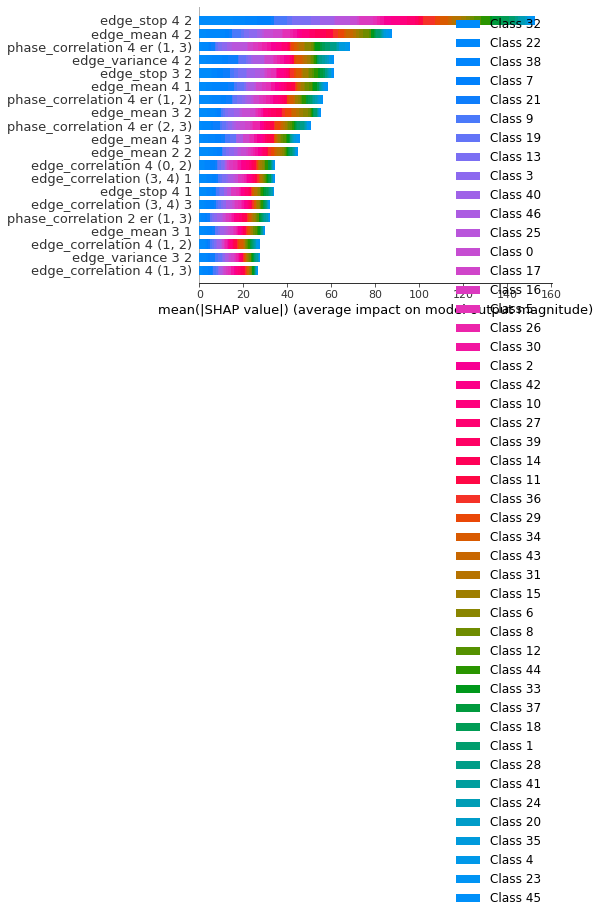

In [19]:
import shap

# Initialize your trained model (make sure it's on the same device as your data)
# Assuming your model is already on the device and named 'model'

# Make sure the background_data is on the same device as the model
background_data = statistics_tensor[:100].to(device)  # Replace 'device' with your actual device, e.g., 'cuda'

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background_data)

# Choose some test data to explain and make sure it is on the same device as your model
test_data = test_statistics_tensor[:10].to(device)  # Replace 'device' with your actual device, e.g., 'cuda'

# Compute SHAP values
shap_values = explainer.shap_values(test_data)
# Convert to numpy array for plotting
#shap_values_np = [s.cpu().numpy() for s in shap_values]

# Plotting the SHAP values with feature names
shap.summary_plot(shap_values, test_data.cpu().numpy(), plot_type="bar", feature_names=ostat_labels)


Try permutation importance

In [20]:
# Function to compute test accuracy
import copy
def compute_test_accuracy(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = y_batch.squeeze()
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += y_batch.size(0)
            correct_samples += (predicted == y_batch).sum().item()
    return 100 * correct_samples / total_samples

In [21]:
##Mal zwei auf einmal vertauschen

test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
test_scaled_array = scaler.transform(test_statistics_array)
#np.random.shuffle(test_scaled_array[:, 2])
#np.random.shuffle(test_scaled_array[:, 0])
# Convert NumPy arrays to PyTorch tensors
test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

# Create the dataset object
test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

batches = 80
test_class_statistics_dataloader_permuted = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

permuted_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader_permuted, device)

In [22]:
# Original test accuracy
original_test_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader, device)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')

Original Test Accuracy: 18.57%


In [23]:
import numpy as np

# Calculate original accuracy
original_test_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader, device)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')

n_features = 150  
n_permutations = 30  
permuted_accuracies = np.zeros((n_features, n_permutations))

for i in range(n_features):
    for j in range(n_permutations):
        # Existing code to permute one feature and get permuted_accuracy
        test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
        test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
        test_scaled_array = scaler.transform(test_statistics_array)
        np.random.shuffle(test_scaled_array[:, i])
         # Convert NumPy arrays to PyTorch tensors
        test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
        test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

        # Create the dataset object
        test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

        batches = 80
        test_class_statistics_dataloader_permuted = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

        permuted_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader_permuted, device)
        permuted_accuracies[i, j] = permuted_accuracy

mean_drops = np.mean(original_test_accuracy - permuted_accuracies, axis=1)
std_drops = np.std(original_test_accuracy - permuted_accuracies, axis=1)

for i in range(n_features):
    mean_drop = mean_drops[i]
    std_drop = std_drops[i]
    print(f"Feature {i}: Mean drop = {mean_drop:.2f}, Std drop = {std_drop:.2f}")
    if mean_drop - std_drop > 0 or mean_drop + std_drop < 0:
        print(f"Feature {i} has statistically significant importance.")

Original Test Accuracy: 18.57%
Feature 0: Mean drop = 0.50, Std drop = 0.55
Feature 1: Mean drop = 0.60, Std drop = 0.51
Feature 1 has statistically significant importance.
Feature 2: Mean drop = 1.62, Std drop = 0.62
Feature 2 has statistically significant importance.
Feature 3: Mean drop = 0.46, Std drop = 0.59
Feature 4: Mean drop = 0.41, Std drop = 0.43
Feature 5: Mean drop = -0.06, Std drop = 0.60
Feature 6: Mean drop = 0.69, Std drop = 0.40
Feature 6 has statistically significant importance.
Feature 7: Mean drop = 0.07, Std drop = 0.36
Feature 8: Mean drop = 0.20, Std drop = 0.48
Feature 9: Mean drop = 0.79, Std drop = 0.35
Feature 9 has statistically significant importance.
Feature 10: Mean drop = 0.50, Std drop = 0.50
Feature 10 has statistically significant importance.
Feature 11: Mean drop = 0.48, Std drop = 0.49
Feature 12: Mean drop = 0.76, Std drop = 0.47
Feature 12 has statistically significant importance.
Feature 13: Mean drop = 0.23, Std drop = 0.38
Feature 14: Mean dro

In [27]:
# Most important stats
high_drop_indices = np.where(mean_drops > 2.5)[0]

print("Indices where mean drop is greater than 3:", high_drop_indices)
high_indices = [26, 51, 62, 65, 69, 73, 77, 84, 87, 92, 93, 97]
high_indices = high_drop_indices
for i in high_indices:
    print(f"Index {i}: {ostat_labels[i]}")

Indices where mean drop is greater than 3: [30 40 44 62 66 74 87 93]
Index 30: edge_mean 1 3
Index 40: edge_mean 2 0
Index 44: edge_mean 2 1
Index 62: edge_mean 3 0
Index 66: edge_mean 3 1
Index 74: edge_mean 3 3
Index 87: edge_mean 4 1
Index 93: edge_mean 4 3
